Given the same dataset,

- extract the most syntactically weighted N-grams, omitting nonsense (‘казалось бы’, ‘возможно предположить’, etc). The main idea is to extract the most valuable data from the text.

- Try different models for a topic extraction. Which one performs better? What metrics were used to evaluate the model?


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import re
import multiprocessing as mp
from string import punctuation
import gensim

Load data:

In [3]:
lenta_data = pd.read_csv('E:/PycharmProjects/data/lenta-ru-news.csv')
lenta_data.head()

c:\program files\python38\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


Clean and preprocessing text data:

In [4]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ситилинк\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from nltk.corpus import stopwords
import re, string
from nltk.stem.snowball import SnowballStemmer

russian_stopwords = stopwords.words("russian")
regex = re.compile('[%s]' % re.escape(string.punctuation))
stemmer = SnowballStemmer("russian") 

def preprocessing(text):
    text = regex.sub('', text)
    text = [token for token in text.split() if token not in russian_stopwords]
    text = [stemmer.stem(token) for token in text] 
    text = [token for token in text if token] 
    return ' '.join(text)

Only 10 000 values from dataset, bcs original dataset is very big and process it take a lot of time:

In [6]:
lenta_data['text'][:10000] = lenta_data['text'][:10000].apply(lambda x: preprocessing(x))

In [7]:
preprocessing_data = pd.DataFrame({'text': lenta_data['text'][:10000]})
preprocessing_data

,text
0,бо сопоцкин друскеник законч отступлен германц...
1,министерств народн просвещен вид происходя чре...
2,штабскапита п н нестер днях увид район желтиев...
3,фотографкорреспондент Daily Mirror рассказыва ...
4,лиц приеха варшав люблин переда туд доставл «ш...
...,...
9995,глав мвд дагеста приказа наряд милиц пригранич...
9996,представител кремл ведут активн диалог губерна...
9997,в москв 20 июл открыва фестивал планет клоунад...
9998,чист американск получ фина уимблдонск теннисн ...


Create the bigrams and trigrams, using gensim:

In [8]:
text = []
for index, row in preprocessing_data.iterrows():
        text.append(row['text'].split())

from gensim.models import Phrases
bigram = Phrases(text) 
trigram = Phrases(bigram[text])

for idx in range(len(text)):
    for token in bigram[text[idx]]:
        if '_' in token:
            text[idx].append(token)
    for token in trigram[text[idx]]:
        if '_' in token:
            text[idx].append(token)

Create the bigrams, using nltk:

In [9]:
texts = []
for index, row in preprocessing_data.iterrows():
        texts.append(row['text'].split())
        
from nltk.util import ngrams
import  collections

bigrams = [ngrams(text, 2) for text in texts]
bigram_freq = [collections.Counter(bigram) for bigram in bigrams]
# look at the most popular bigrams in the third and fourth text
bigram_freq[2].most_common(5), bigram_freq[3].most_common(5)

([(('лиш', 'птиц'), 4),
  (('нестер', 'погиб'), 2),
  (('сентябр', '1914'), 2),
  (('1914', 'год'), 2),
  (('безбрежн', 'неб'), 2)],
 [(('фотографкорреспондент', 'Daily'), 1),
  (('Daily', 'Mirror'), 1),
  (('Mirror', 'рассказыва'), 1),
  (('рассказыва', 'случа'), 1),
  (('случа', 'котор'), 1)])

Create LDA-model

In [10]:
from gensim.corpora.dictionary import Dictionary
from numpy import array

dictionary = Dictionary(text)
dictionary.filter_extremes(no_below=10, no_above=0.1)

corpus = [dictionary.doc2bow(doc) for doc in text]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus))

Количество уникальных токенов: 13658
Количество документов: 10000


In [19]:
from gensim.models.ldamulticore import LdaMulticore

model = LdaMulticore(corpus = corpus,id2word = dictionary, num_topics = 14)
model.show_topics()

[(10,
  '0.003*"по_дан" + 0.003*"боевик" + 0.003*"как_сообщ" + 0.002*"сайт" + 0.002*"сообща_ри" + 0.002*"так_образ" + 0.002*"по_мнен" + 0.002*"в_сред" + 0.002*"территор" + 0.002*"интернет"'),
 (12,
  '0.004*"по_дан" + 0.003*"владимир_путин" + 0.003*"по_мнен" + 0.002*"президент_росс" + 0.002*"сообща_ри" + 0.002*"выбор" + 0.002*"путин" + 0.002*"боевик" + 0.002*"глав_государств" + 0.002*"закон"'),
 (1,
  '0.005*"по_дан" + 0.004*"как_сообщ" + 0.003*"сообща_ри" + 0.002*"в_сред" + 0.002*"милиц" + 0.002*"област" + 0.002*"жил_дом" + 0.001*"в_результат" + 0.001*"обнаруж" + 0.001*"американск"'),
 (0,
  '0.002*"переда_ри" + 0.002*"как_сообщ" + 0.002*"миллиард_доллар" + 0.002*"американск" + 0.002*"сообща_ри" + 0.002*"процент" + 0.002*"выбор" + 0.002*"1999_год" + 0.002*"прошл_год" + 0.002*"управлен"'),
 (3,
  '0.002*"программ" + 0.002*"по_дан" + 0.002*"как_сообщ" + 0.002*"боевик" + 0.002*"рубл" + 0.002*"сайт" + 0.001*"так_образ" + 0.001*"люд" + 0.001*"федеральн_сил" + 0.001*"в_результат"'),
 (4,
  

In [ ]:
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [46]:
We need to define the optimal numbers of topics:

We need to define the optimal numbers of topics:

In [12]:
from gensim.models.coherencemodel import CoherenceModel

def calc_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values = calc_coherence_values(dictionary = dictionary, corpus=corpus, texts=text, start = 2, limit = 20, step = 2)

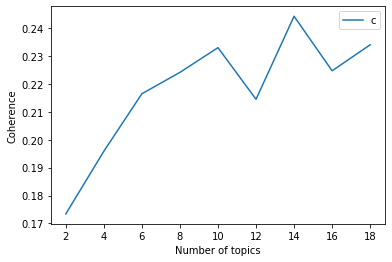

In [13]:
limit, start, step = 20, 2, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

The best coherence - for ~14 topics.


LSA-model

In [14]:
from gensim.models import LsiModel

In [18]:
lsamodel = LsiModel(corpus, num_topics = 14, id2word = dictionary) 
lsamodel.print_topics(num_topics = 14, num_words = 10)

[(0,
  '0.148*"владимир_путин" + 0.125*"по_дан" + 0.122*"по_мнен" + 0.117*"путин" + 0.115*"выбор" + 0.114*"процент" + 0.109*"как_сообщ" + 0.107*"сообща_ри" + 0.098*"2000_год" + 0.091*"закон"'),
 (1,
  '-0.325*"боевик" + -0.275*"федеральн_сил" + -0.183*"по_дан" + -0.160*"населен_пункт" + -0.156*"войск" + -0.151*"грозн" + 0.139*"выбор" + -0.139*"чеченск" + -0.137*"северн_кавказ" + 0.133*"процент"'),
 (2,
  '0.388*"владимир_путин" + 0.281*"путин" + 0.185*"выбор" + -0.149*"рубл" + -0.147*"2000_год" + 0.136*"президент_росс" + -0.133*"миллион_доллар" + -0.130*"миллиард_доллар" + -0.127*"процент" + -0.126*"миллиард"'),
 (3,
  '-0.442*"владимир_путин" + -0.320*"путин" + 0.281*"выбор" + 0.218*"избирательн" + 0.180*"кандидат" + 0.120*"депутат" + 0.111*"цик" + 0.100*"избирательн_объединен" + 0.098*"комисс" + -0.096*"встреч"'),
 (4,
  '-0.326*"рубл" + -0.297*"процент" + 0.197*"сайт" + -0.179*"2000_год" + -0.159*"миллиард_рубл" + 0.149*"интернет" + -0.126*"федеральн_сил" + -0.126*"боевик" + -0.124*

In [36]:
def calc_coherence_values_Lsi(dictionary, corpus, texts, limit, start = 2, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, id2word = dictionary, num_topics = num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values_Lsi = calc_coherence_values(dictionary = dictionary, corpus=corpus, texts=text, start = 2, limit = 20, step = 2)

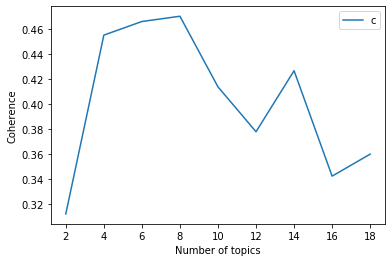

In [38]:

limit, start, step = 20, 2, 2
x = range(start, limit, step)
plt.plot(x, coherence_values_Lsi)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

The best coherence - for ~8 topics.

PLSA-model

In [39]:
from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA

In [43]:
n_topics = 10
plsa = PLSA(corpus, n_topics, True)
plsa

AttributeError: 'list' object has no attribute 'n_docs'